
Introduction 
===

In this notebook we will demonstrate two methods of 

### 1. Willmore Energy Flow:

The Willmore energy is defined by: 

$$
E=\int_{M} H^{2} d A
$$

The discrete Willmore energy is defined by:

$$
E_{\text {discrete }}=\sum_{i \in V}(H N)_{i}^{2} / A_{i}
$$

Noting that
$$
\nabla E_{W}(f) = \frac{1}{4}\langle\langle\Delta f, \Delta f\rangle\rangle=\frac{1}{4}\left\langle\left\langle\Delta^{2} f, f\right\rangle\right\rangle
$$

$$
\dot{f} = -\nabla E_{W}(f) =-\frac{1}{2} \Delta^{2} f
$$

##### NOTE: This should be $C_{i}$ and not $A_{i}$? I believe this is a typo in the notes. Read the papers again.
##### NOTE 2: Why do we only devide by $C_{i}$  once; $H N)_{i}$ is the integrated mean curvature over a vertex neighbourhood, so $(H N)_{i}^{2}$ contains a factor of squared area and we cancel one of those factors out. Remember that we want to integrate mean curvature squared over the whole surface.

The change in time is defined by:
$$
\frac{d}{d t}= -\nabla_{f} E
$$


### 2. Mean Curvature Flow:

Energy defined by:
$$
E(f)=\int_{M} d A
$$

Differential energy by:
$$
\delta E=2 H N d A
$$

Surface change over time:
$$
\frac{d}{d t} f=-2 H N
$$

Discretised differential:

$$
f_{i}^{k+1}=f_{i}^{k}-\frac{\tau}{2} \sum_{i j \in \operatorname{St}(i)}\left(\cot \alpha_{i j}+\cot \beta_{i j}\right)\left(f_{j}^{k}-f_{i}^{k}\right)
$$

### 3. Gauss Energy Flow (TODO):

Energy defined by:
$$
E(f)=\int_{M} H d A
$$

Differential energy by:
$$
\delta E=K N d A
$$

Surface change over time:
$$
\frac{d}{d t} f=-K N
$$

Discretised differential:

$$
f_{i}^{k+1}=f_{i}^{k}-\frac{\tau}{2} \sum_{i j \in \mathrm{St}(i)} \frac{\varphi_{i j}}{\ell_{i j}}\left(f_{j}^{k}-f_{i}^{k}\right)
$$


In [2]:
# NOTE: CP is used for the Equation of State:
try:
    from CoolProp.CoolProp import PropsSI
except ImportError:
    import sys
    !{sys.executable} -m pip install coolprop

In [3]:
# Imports and physical parameters
# Imports and physical parameters
import numpy as np
import scipy
#from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from skimage import data, io
import sys
import skimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
%matplotlib notebook

from ddgclib import *
from ddgclib._complex import Complex
#from ddgclib.curvatures import plot_surface, curvature

# Colour scheme for surfaces
db = np.array([129, 160, 189]) / 255  # Dark blue
lb = np.array([176, 206, 234]) / 255  # Light blue

# Parameters for a water droplet in air at standard laboratory conditions
#gamma = 0.0728  # N/m, surface tension of water at 20 deg C
gamma =71.03e-3  # N/m kg/s^2 = N m-1 surface tension of water used in SE
Volmue = 0.02962  # Volume (0units unknown (mL?) 0.01 mL = 0.01 cm^3)
rho = 998   # kg/m3, density
g = 9.81  # m/s2
# Capillary rise parameters
theta_p = 69.4  * np.pi /180.0

#from ddgclib.curvatures import plot_surface, curvature

# Colour scheme for surfaces
db = np.array([129, 160, 189]) / 255  # Dark blue
lb = np.array([176, 206, 234]) / 255  # Light blue


#!conda install --yes --prefix {sys.prefix} skimage


# Parameters for a water droplet in air at standard laboratory conditions
def eos(P=101.325, T=298.15):
    # P in kPa T in K 
    return PropsSI('D','T|liquid',298.15,'P',101.325,'Water') # density kg /m3

# Surface tension of water gamma(T)
def IAPWS(T=298.15): 
    T_C = 647.096  # K, critical temperature
    return 235.8e-3 * (1 -(T/T_C))**1.256 * (1 - 0.625*(1 - (T/T_C)))  # N/m

T_0 = 273.15 + 25  # K, initial tmeperature
P_0 = 101.325  # kPa, Ambient pressure
gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
rho_0 = eos(P=P_0, T=T_0)  # kg/m3, density
g = 9.81  # m/s2

from ddgclib import *
from ddgclib._complex import Complex
#from ddgclib.curvatures import plot_surface, curvature

# Colour scheme for surfaces
db = np.array([129, 160, 189]) / 255  # Dark blue
lb = np.array([176, 206, 234]) / 255  # Light blue


In [5]:
def mean_flow(HC, bV, m_0, tau=0.5, h_0=0.0, gravity_field=False):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :return:
    """
    #rint('-')
    # Define the normals (NOTE: ONLY WORKS FOR CONVEX SURFACES)
    # Note that the cache HC.V is an OrderedDict:
    N = []

    V = set(HC.V) - bV
    V_a = []
    f = []
    
    for v in V:
        f.append(v.x_a)
        
    f = np.array(f)
    #COM = numpy.average(nonZeroMasses[:,:3], axis=0, weights=nonZeroMasses[:,3])
    com = np.average(f, axis=0)
    #print(f'com = {com}')
    for v in V:         
        N.append(normalized(v.x_a - com)[0])
    
    NdA = []
    HNdA = []
    HN = []  # sum(HNdA_ij, axes=0) / C_ijk
    C = []
    for i, v in enumerate(V):
        F, nn = vectorise_vnn(v)
        try:
            c_outd = curvatures(F, nn, n_i=N[i])
        except IndexError:
            print(f'WARNING, IndexError in loop')
            c_outd = {}
            c_outd['HNdA_i'] = np.zeros(3)
            c_outd['C_ijk'] = np.array([1.0])
            c_outd['NdA_i'] = np.zeros(3)
            
        NdA.append(c_outd['NdA_i'])
        HN.append(c_outd['HNdA_i']/np.sum(c_outd['C_ijk']))
        C.append(np.sum(c_outd['C_ijk']))
        #f.append(v.x_a)

    H = np.nan_to_num(-np.array(HN))
    NdA = np.nan_to_num(np.array(NdA))
    dP = -gamma * H  # Hydrostatic pressure
    
    # Add volume perservation
    # First note that the volume gradient points in the same direction as the 
    # vector area NV (i.e. they are the same up to a constant factor).
    # Therefore we simply need to compute the different between the current 
    # volume and the equilibrium volume and add a scalar multiplier
    Rho = []
    for dp in dP:
        #p = 101.325 + dp
        p = 101.325 + np.sum(dp)  #TODO: Validate
        #print(f'p = {p}')
        rho = eos(P=p)  # kg m-3
        Rho.append(rho)
        # TODO: Compute local signed 
    Rho = np.array(Rho) 
    #print(f'Rho = {Rho}')
    V_eq = m_0/Rho  # m-3
    V_eq = np.mean(m_0/Rho)  # m-3
    V_eq =  0.02962e-6   # TEMPORARY
    print(f'V_eq = {V_eq}')
    
    N = np.array(N)
    #print(f'N_i = {N}')
    #print(f'NdA = {NdA}')
    if 0:
        print(f'np.sum(N) = {np.sum(N)}')
        print(f'np.sum(NdA) = {np.sum(NdA)}')
        print(f'np.sum(NdA*N) = {np.sum(NdA*N)}')
        print(f'NdA.dot(N) = {NdA.T.dot(N)}')
        print(f'sum NdA.dot(N) = {np.sum(NdA.T.dot(N))}')
    
    V_current = np.sum(C)/6.0
    print(f'V_current = {V_current}')
    #dV =  -(V_current - V_eq)*H
    V_current = V_eq *0.9   # TEMPORARY
    dV = 2* 6*(V_eq - V_current)*N
    
    # Add gravity force rho * g * h (Validated)
    if gravity_field:
        h = f[:, 2] - h_0
        g_v = np.zeros_like(dP)
        g_v[:, 2] = -g
        dg = rho*(h*g_v.T).T
    else:
        dg = np.zeros_like(dP)
    
    #dV = np.zeros_like(dP)
    
    df = dP + dV + dg
    #print(f'df = {df}')
    f_k = f + tau * df
    #print(f'df = {df}')
    for i, v in enumerate(V):
        #print(f'f_k[i] = {f_k[i]}')
        HC.V.move(HC.V[tuple(v.x_a)], tuple(f_k[i]))

    return HC

In [6]:

def mean_flow_old(HC, bV, h_0, tau=0.5):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :return:
    """
    #rint('-')
    # Define the normals (NOTE: ONLY WORKS FOR CONVEX SURFACES)
    # Note that the cache HC.V is an OrderedDict:
    N_i = []

    V = set(HC.V) - bV
    V_a = []
    f = []
    for v in V:
        N_i.append(normalized(v.x_a - np.array([0.0, 0.0, 0.0]))[0])
        f.append(v.x_a)
        
    f = np.array(f)
    HNdA = []
    HN = []  # sum(HNdA_ij, axes=0) / C_ijk
    for i, v in enumerate(V):
        F, nn = vectorise_vnn(v)
        try:
            c_outd = curvatures(F, nn, n_i=N_i[i])
        except IndexError:
            print(f'WARNING, IndexError in loop')
            c_outd = {}
            c_outd['HNdA_i'] = np.zeros(3)
            c_outd['C_ijk'] = np.array([1.0])
            
        HN.append(c_outd['HNdA_i']/np.sum(c_outd['C_ijk']))
        #f.append(v.x_a)

    #print(f'HNdA = { HNdA}')
    #print(f"(np.sum(c_outd['H_ij_sum'])/np.sum(c_outd['C_ijk']))  = {(np.sum(c_outd['H_ij_sum'])/np.sum(c_outd['C_ijk']))}")
    #print(f'HN = {HN}')
    #H = np.nan_to_num(-(1 / 2.0)*np.array(HN))
    H = np.nan_to_num(-np.array(HN))
    df = -gamma * H  # Hydrostatic pressure
    # Add gravity force rho * g * h (Validated)
    h = f[:, 2]
    g_v = np.zeros_like(df)
    g_v[:, 2] = -g
    df = df + rho*(h*g_v.T).T
    # Add volume perservation
    # First note that the volume gradient points in the same direction as the 
    # vector area NV (i.e. they are the same up to a constant factor).

    #print(f'df = {df}')
    f_k = f + tau * df
    print(f'df = {df}')
    for i, v in enumerate(V):
        #print(f'f_k[i] = {f_k[i]}')
        HC.V.move(HC.V[tuple(v.x_a)], tuple(f_k[i]))

    return HC

def Gauss_Bonnet(HC):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :return:
    """
    ## Computer Euler Characteristic:
    # Compute the number of vertices
    V = len(list(HC.V))
    # Compute the dges
    E = 0
    for v in HC.V:
        E += len(list(v.nn))
        
    E = E/2.0 # We have added precisely twice the number of edges through adding each connection
    # Compute the faces
    HC.dim = 2  # We have taken the boundary of the sphere
    HC.vertex_face_mesh()
    Faces = HC.simplices_fm
    F = len(Faces)
    
    # Compute Euler
    chi = V - E + F
    print(f'V = {V}')
    print(f'E = {E}')
    print(f'F = {F}')
    chi = V - E + F
    print(f'$\chi = V - E + F$ = {chi}')   
    
    
    return 

In [ ]:
# Test changes for errors:
mean_flow(HC, bV, 1.0, tau=0.01)


In [10]:
def regularize(HC, bV, tau_i=1e-1):
    """
    TODO: We need a solution for when the mesh has already degenerated 
          and np.min([minVn_norm, tau_glob]) = 0.0
    """
    V = set(HC.V) - bV
    f = []
    for v in V:
        f.append(v.x_a)
        
    f = np.array(f)
    V_corr = []
    tau_glob = np.inf
    for i, v in enumerate(V):
        Vn = []
        for vn in v.nn:
            Vn.append(vn.x_a - v.x_a)
        Vn = np.array(Vn)
        Vn_norm = np.linalg.norm(Vn, axis=1)
        maxVn_norm = np.max(np.linalg.norm(Vn, axis=1))
        minVn_norm = np.min(np.linalg.norm(Vn, axis=1))
        tau_glob = np.min([minVn_norm, tau_glob])
        meanvn_norm = np.mean(Vn_norm)
        v_corr = np.zeros_like(Vn[0])
        for vn, vn_norm in zip(Vn, Vn_norm):
            #print(f'v_corr = {v_corr}')
            if vn_norm >= meanvn_norm:
                c = minVn_norm - vn_norm
            else:
                c = maxVn_norm - vn_norm

            #print(f'c ={c}')
            v_corr = v_corr - c * vn
            #df[i] += 100 *c * vn

        np.sum(v_corr, axis=-1)    
        V_corr.append(v_corr)
    
    tau = tau_glob
    V_corr = np.array(V_corr)
    df = V_corr
    f_k = f + tau * df
    print(f' tau  = { tau }')
    for i, v in enumerate(V):
        #print(f'f_k[i] = {f_k[i]}')
        HC.V.move(HC.V[tuple(v.x_a)], tuple(f_k[i]))
        
    return HC

Image processing
====

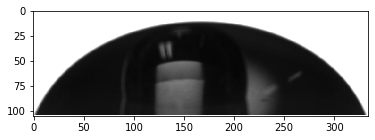

In [13]:
img_str = './data/dropB_cropped.png'
I_png=plt.imread(img_str)
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
gray = rgb2gray(I_png)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()


In [14]:
import skimage
import skimage.feature
import skimage.viewer
import sys

# read command-line arguments
#filename = sys.argv[1]
filename =img_str
#sigma = 0.2
#low_threshold = float(sys.argv[3])
#high_threshold = float(sys.argv[4])
sigma = 5.0#2.0
sigma = 10.0#2.0
low_threshold = 0.1
high_threshold = 0.3

image = skimage.io.imread(fname=filename, as_gray=True)
#viewer = skimage.viewer(image=image)
viewer = skimage.viewer.ImageViewer(image=image)
viewer.show()
image_cropped = image#[210:400,180:440]

sigma = 3.0
low_threshold = 0.66#0.05 
high_threshold = 0.4
if 1:
    edges = skimage.feature.canny(
        image=image_cropped,
        sigma=sigma,
        low_threshold=low_threshold,
        #high_threshold=high_threshold,
    )


In [15]:
viewer = skimage.viewer.ImageViewer(edges)
viewer.show()

[]

In [16]:
xpos, ypos = np.argwhere(edges)[:, 0], np.argwhere(edges)[:, 1]
xpos, ypos


(array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19,
        19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21,
        21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23,
        23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26,
        26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29,
        29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32,
        32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35,
        35, 

In [17]:
np.savetxt('./data/output.txt', np.argwhere(edges), delimiter=';')

In [18]:
x0=166  # TODO: Detect maximum of edge contour to find symmetry automatically

#%%

k = 473 - 376 # a known length in pixel coordinates
l= 0.8 # this length in world coordinates in mm 
scale=l/k
scale = scale *1e-3  # Length in m

In [19]:
ymin = y0 #TODO: Check if this is correct
r=(xpos-x0)*scale;
"""translate the r-coordinate in pixel coordinates and convert into world coordinates"""
z=-(ypos-ymin)*scale;
"""same for z-coordinate"""
r, z

NameError: name 'y0' is not defined

In [20]:

plt.figure()
plt.scatter(z,-r)

NameError: name 'r' is not defined

<Figure size 432x288 with 0 Axes>

In [21]:

sdx= 0.00271746
sy0 = 0.000552137
syf = 0.00127012
sdy = syf - sy0
sdx, sdy

(0.00271746, 0.0007179830000000001)

In [22]:
z_c = z + sdx/2.0
plt.figure()
plt.scatter(z_c,-r)

NameError: name 'r' is not defined

<Figure size 432x288 with 0 Axes>

In [23]:

# Parameters for a water droplet in air at standard laboratory conditions
#gamma = 0.0728  # N/m, surface tension of water at 20 deg C
gamma = 71.03e-3  # N/m kg/s^2 = N m-1 surface tension of water used in SE
Volume = 0.02962  # Volume (0units unknown (mL?) 0.01 mL = 0.01 cm^3)
Volume = 0.02962e-6  # Volume (m)
Volume = 0.02962e-6   # Volume (m)
#Volume= 2.9619999999999997e-08  # V_eq 
#rho = 998   # kg/m3, density

m_0 = rho_0 * Volume  # kg

# Capillary rise parameters
theta_p = 69.4  * np.pi /180.0
# Capillary rise parameters
#TODO: COMPUTE CORRECT VOLUME OF CYLLINDER
#r = 0.5e-2  # Radius of the droplet sphere

#r = dx/2.0 
#r = 1
#theta_p = 0.35  # Contact angle

r = sdx/2.0 

h = Volume / ( np.pi * r**2 )  # V =  np.pi * r**2 * h 
h
#h = 0.0012  # TEMPORARY, Volume is way too low, problem with units?
#Volume_est =  np.pi * r**2 * h 
#Volume_est

0.005107035215221801

In [24]:

Volume, np.pi * r**2 * h

(2.962e-08, 2.962e-08)

C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_complex.py:3751: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


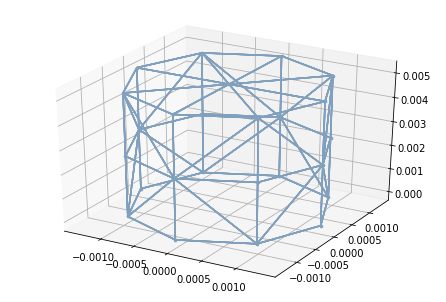

In [25]:

# Initiate a cubical complex
HC = Complex(3, domain=[(-r, r),]*3)
HC.triangulate()

for i in range(1):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == -r) or np.any(v.x_a == r):
        if np.any(v.x_a[2] == -r):
            if np.any(v.x_a[0:2] == -r) or  np.any(v.x_a[0:2] == r):
                continue
            else:
                del_list.append(v)
        else:
            continue    
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)

# Shrink to circle and move to zero
for v in HC.V:
    x = v.x_a[0]
    y = v.x_a[1]
    f_k = [x * np.sqrt(r**2 - y**2/2.0)/r, y * np.sqrt(r**2 - x**2/2.0)/r, v.x_a[2]]
    HC.V.move(v, tuple(f_k)) 
    
# Move up to zero (NOTE: DO NOT DO THIS IN THE CIRCLE LOOP 
# BECUASE SAME VERTEX INDEX BREAKS CONNECTIONS IN LOOP DURING MOVE: 
# TODO: FIX THIS IN THE hyperct LIBRARY CODE)
for v in HC.V:
    if (v.x_a[2] == -r) or (v.x_a[2] == 0.0):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))  
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == -r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))       
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))     
    
## Move to h
for v in HC.V:
    if (v.x_a[2] == 0.0) or (v.x_a[2] == r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + h - 2*r]
    HC.V.move(v, tuple(f_k))  
    
for v in HC.V:
    if (v.x_a[2] == r):
        f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + 0.5*h - r]
        HC.V.move(v, tuple(f_k))  
    
# Find set of boundary vertices
bV = set()
for v in HC.V:
    #print('-')
    #print(f'v.x_a = {v.x_a}')
    #print(f'v.x_a[2] == 0.0 = {v.x_a[2] == 0.0}')
    if v.x_a[2] == 0.0:
        bV.add(v)
        #print(f'bV = {bV}')
    else:
        continue


fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

#axes.set_xlim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_ylim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_zlim3d(-(0.1*r + r) , 0.1*r + 2*r)

In [26]:

set(HC.V), set(HC.V) - bV

({<ddgclib._vertex.VertexCube at 0x1fcb38ab048>,
  <ddgclib._vertex.VertexCube at 0x1fcb390ef88>},
 {<ddgclib._vertex.VertexCube at 0x1fcb38ab708>,
  <ddgclib._vertex.VertexCube at 0x1fcb390ef88>})

In [27]:

#%%

len(set(HC.V)), len(set(bV)), len(set(HC.V) - bV)


(25, 8, 17)

In [28]:


#%%

HC.V.print_out()


Vertex cache of size: 25:
Vertex: (-0.0009607671968015978, -0.0009607671968015978, 0.0)
Connections: (0.0, -0.00135873, 0.0) (0.0, -0.00135873, 0.0025535176076109008) (-0.0009607671968015978, -0.0009607671968015978, 0.0025535176076109008) (-0.00135873, 0.0, 0.0) (-0.00135873, 0.0, 0.0025535176076109008) 
Vertex: (0.0009607671968015978, -0.0009607671968015978, 0.0)
Connections: (0.0, -0.00135873, 0.0) (0.00135873, 0.0, 0.0) (0.0, -0.00135873, 0.0025535176076109008) (0.00135873, 0.0, 0.0025535176076109008) (0.0009607671968015978, -0.0009607671968015978, 0.0025535176076109008) 
Vertex: (-0.0009607671968015978, 0.0009607671968015978, 0.0)
Connections: (-0.00135873, 0.0, 0.0025535176076109008) (-0.00135873, 0.0, 0.0) (0.0, 0.00135873, 0.0025535176076109008) (0.0, 0.00135873, 0.0) (-0.0009607671968015978, 0.0009607671968015978, 0.0025535176076109008) 
Vertex: (0.0009607671968015978, 0.0009607671968015978, 0.0)
Connections: (0.00135873, 0.0, 0.0) (0.0009607671968015978, 0.0009607671968015978,

In [29]:

#%%

#TEST
V_defective = [HC.V[(0.0, -r, 0.0)],   HC.V[(0.0, r, 0.0)], HC.V[(-r, 0.0, 0.0)], HC.V[( r, 0.0, 0.0)]]  
for v in V_defective:
    print(v)
    print(f'v.nn = {v.nn}')

v.nn = {<ddgclib._vertex.VertexCube object at 0x000001FCB390EF08>, <ddgclib._vertex.VertexCube object at 0x000001FCB38B6348>, <ddgclib._vertex.VertexCube object at 0x000001FCB38AB048>}
v.nn = {<ddgclib._vertex.VertexCube object at 0x000001FCB38AB508>, <ddgclib._vertex.VertexCube object at 0x000001FCB38AB4C8>, <ddgclib._vertex.VertexCube object at 0x000001FCB38B6408>}
v.nn = {<ddgclib._vertex.VertexCube object at 0x000001FCB390EF08>, <ddgclib._vertex.VertexCube object at 0x000001FCB38AB4C8>, <ddgclib._vertex.VertexCube object at 0x000001FCB38B6388>}
v.nn = {<ddgclib._vertex.VertexCube object at 0x000001FCB38AB508>, <ddgclib._vertex.VertexCube object at 0x000001FCB38AB048>, <ddgclib._vertex.VertexCube object at 0x000001FCB38B63C8>}


In [30]:
# Ensure the norm is correct
print(f'Norm test (all should be equal to r = {r}):')
for v in HC.V:
    print(f'v.x_a = {v.x_a}')
    #print(f'v in bHC_V: {v in bHC_V}')
    print(f'norm = {np.linalg.norm(v.x_a - HC.V[(0.0, 0.0, 0.0)].x_a)}')
# Ensure that the boundary doesn't contain the origin
print(f'Boundary test:')
for v in bV:
    print(f'v.x_a = {v.x_a}')
    if np.linalg.norm(v.x_a - HC.V[(0.0, 0.0, 0.0)].x_a) in bV:
        print(f'FAILURE: ORIGIN in bHC_V')

Norm test (all should be equal to r = 0.00135873):
v.x_a = [-0.00096077 -0.00096077  0.        ]
norm = 0.00135873
v.x_a = [ 0.00096077 -0.00096077  0.        ]
norm = 0.00135873
v.x_a = [-0.00096077  0.00096077  0.        ]
norm = 0.00135873
v.x_a = [0.00096077 0.00096077 0.        ]
norm = 0.00135873
v.x_a = [ 0.         -0.00135873  0.        ]
norm = 0.00135873
v.x_a = [-0.00135873  0.          0.        ]
norm = 0.00135873
v.x_a = [0.00135873 0.         0.        ]
norm = 0.00135873
v.x_a = [0.         0.00135873 0.        ]
norm = 0.00135873
v.x_a = [0.00096077 0.00096077 0.00510704]
norm = 0.005284690710194457
v.x_a = [-0.00096077 -0.00096077  0.00510704]
norm = 0.005284690710194457
v.x_a = [ 0.00096077 -0.00096077  0.00510704]
norm = 0.005284690710194457
v.x_a = [-0.00096077  0.00096077  0.00510704]
norm = 0.005284690710194457
v.x_a = [0.         0.         0.00510704]
norm = 0.0051070352152218015
v.x_a = [ 0.         -0.00135873  0.00510704]
norm = 0.005284690710194457
v.x_a =

In [ ]:

# Initiate a cubical complex
HC = Complex(3, domain=[(-r, r),]*3)
HC.triangulate()

for i in range(1):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == -r) or np.any(v.x_a == r):
        if np.any(v.x_a[2] == -r):
            if np.any(v.x_a[0:2] == -r) or  np.any(v.x_a[0:2] == r):
                continue
            else:
                del_list.append(v)
        else:
            continue    
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)

# Shrink to circle and move to zero
for v in HC.V:
    x = v.x_a[0]
    y = v.x_a[1]
    f_k = [x * np.sqrt(r**2 - y**2/2.0)/r, y * np.sqrt(r**2 - x**2/2.0)/r, v.x_a[2]]
    HC.V.move(v, tuple(f_k)) 
    
# Move up to zero (NOTE: DO NOT DO THIS IN THE CIRCLE LOOP 
# BECUASE SAME VERTEX INDEX BREAKS CONNECTIONS IN LOOP DURING MOVE: 
# TODO: FIX THIS IN THE hyperct LIBRARY CODE)
for v in HC.V:
    if (v.x_a[2] == -r) or (v.x_a[2] == 0.0):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))  
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == -r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))       
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))     
    
## Move to h
for v in HC.V:
    if (v.x_a[2] == 0.0) or (v.x_a[2] == r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + h - 2*r]
    HC.V.move(v, tuple(f_k))  
    
for v in HC.V:
    if (v.x_a[2] == r):
        f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + 0.5*h - r]
        HC.V.move(v, tuple(f_k))  
    
# Find set of boundary vertices
bV = set()
for v in HC.V:
    #print('-')
    #print(f'v.x_a = {v.x_a}')
    #print(f'v.x_a[2] == 0.0 = {v.x_a[2] == 0.0}')
    if v.x_a[2] == 0.0:
        bV.add(v)
        #print(f'bV = {bV}')
    else:
        continue


#axes.set_xlim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_ylim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_zlim3d(-(0.1*r + r) , 0.1*r + 2*r)



for i in range(100):
    HC = mean_flow(HC, bV, m_0, tau=0.000001, h_0=0.0, gravity_field=True)
    for j in range(2000):
        HC = regularize(HC, bV, tau=0.00001)
 
 
#TODO: FInd droplet height
if 0:
    h_f = 2 *h_jurin
    for v in HC.V:
        if v in bV:
            continue
        else:    
            h_f = min(v.x[2], h_f)
        
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

In [ ]:

# Initiate a cubical complex
HC = Complex(3, domain=[(-r, r),]*3)
HC.triangulate()

for i in range(1):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == -r) or np.any(v.x_a == r):
        if np.any(v.x_a[2] == -r):
            if np.any(v.x_a[0:2] == -r) or  np.any(v.x_a[0:2] == r):
                continue
            else:
                del_list.append(v)
        else:
            continue    
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)

# Shrink to circle and move to zero
for v in HC.V:
    x = v.x_a[0]
    y = v.x_a[1]
    f_k = [x * np.sqrt(r**2 - y**2/2.0)/r, y * np.sqrt(r**2 - x**2/2.0)/r, v.x_a[2]]
    HC.V.move(v, tuple(f_k)) 
    
# Move up to zero (NOTE: DO NOT DO THIS IN THE CIRCLE LOOP 
# BECUASE SAME VERTEX INDEX BREAKS CONNECTIONS IN LOOP DURING MOVE: 
# TODO: FIX THIS IN THE hyperct LIBRARY CODE)
for v in HC.V:
    if (v.x_a[2] == -r) or (v.x_a[2] == 0.0):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))  
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == -r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))       
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))     
    
# Find set of boundary vertices
bV = set()
for v in HC.V:
    #print('-')
    #print(f'v.x_a = {v.x_a}')
    #print(f'v.x_a[2] == 0.0 = {v.x_a[2] == 0.0}')
    if v.x_a[2] == 0.0:
        bV.add(v)
        #print(f'bV = {bV}')
    else:
        continue


for i in range(1):
    HC = mean_flow(HC, bV, h_0=h_0, 
                   tau=1e-5
                   #tau=1e-2
                  )
 
#TODO: FInd droplet height
if 0:
    h_f = 2 *h_jurin
    for v in HC.V:
        if v in bV:
            continue
        else:    
            h_f = min(v.x[2], h_f)
        
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

#axes.set_xlim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_ylim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_zlim3d(-(0.1*r + r) , 0.1*r + 2*r)


In [ ]:

# Initiate a cubical complex
HC = Complex(3, domain=[(-r, r),]*3)
HC.triangulate()

for i in range(1):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == -r) or np.any(v.x_a == r):
        if np.any(v.x_a[2] == -r):
            if np.any(v.x_a[0:2] == -r) or  np.any(v.x_a[0:2] == r):
                continue
            else:
                del_list.append(v)
        else:
            continue    
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)

# Shrink to circle and move to zero
for v in HC.V:
    x = v.x_a[0]
    y = v.x_a[1]
    f_k = [x * np.sqrt(r**2 - y**2/2.0)/r, y * np.sqrt(r**2 - x**2/2.0)/r, v.x_a[2]]
    HC.V.move(v, tuple(f_k)) 
    
# Move up to zero (NOTE: DO NOT DO THIS IN THE CIRCLE LOOP 
# BECUASE SAME VERTEX INDEX BREAKS CONNECTIONS IN LOOP DURING MOVE: 
# TODO: FIX THIS IN THE hyperct LIBRARY CODE)
for v in HC.V:
    if (v.x_a[2] == -r) or (v.x_a[2] == 0.0):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))  
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == -r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))       
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))     
    
# Find set of boundary vertices
bV = set()
for v in HC.V:
    #print('-')
    #print(f'v.x_a = {v.x_a}')
    #print(f'v.x_a[2] == 0.0 = {v.x_a[2] == 0.0}')
    if v.x_a[2] == 0.0:
        bV.add(v)
        #print(f'bV = {bV}')
    else:
        continue


for i in range(30):
    HC = mean_flow(HC, bV, h_0=h_0, 
                   tau=1e-5
                   #tau=1e-2
                  )
    #for j in range(10):
     #   HC = regularize(HC, bV)
 
#for j in range(1000):
#    HC = regularize(HC, bV)
 
#TODO: FInd droplet height
if 0:
    h_f = 2 *h_jurin
    for v in HC.V:
        if v in bV:
            continue
        else:    
            h_f = min(v.x[2], h_f)
        
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

#axes.set_xlim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_ylim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_zlim3d(-(0.1*r + r) , 0.1*r + 2*r)
